# Mutual Fund Style Classification
Team Mmeber:
Ruizhi Xu
---

## Project Overview
This notebook implements a full pipeline to classify mutual funds into **Balanced Fund (Low Risk)**, **Fixed Income Long Only (Low Risk)**, or **Equity Long Only (Low Risk)**:

1. Validate existing labels with Retrieval‑Augmented Generation (RAG) using LangChain + OpenAI GPT.
2. Use RAG labels as ground‑truth to train classical ML models on custom Word2Vec embeddings.
3. Evaluate models (Nearest‑Centroid baseline, KNN, Logistic Regression) and visualise results.


In [ ]:
import os, glob, re, numpy as np, pandas as pd
import openai
import matplotlib.pyplot as plt, seaborn as sns
import nltk, gensim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import re, json
from collections import Counter
from rapidfuzz import process, fuzz
import random
import langchain
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from gensim.utils import simple_preprocess
from sklearn.model_selection import GridSearchCV

### 1  Load Data and Set Environment

In [60]:
os.environ["OPENAI_API_KEY"] = "sk-xxxxxx"
openai.api_key = os.environ["OPENAI_API_KEY"]

SEED = 38
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

gensim.models.word2vec.FAST_VERSION = 1 # set workers=1 for full repeatability

In [5]:
# 1  Read mutual fund with label csv
df = pd.read_csv('MutualFundLabels.csv')

# 2  Keep only the three target strategies
TARGET = [
    "Balanced Fund (Low Risk)",
    "Fixed Income Long Only (Low Risk)",
    "Equity Long Only (Low Risk)",
]
filtered = df[df["Ivestment Strategy"].isin(TARGET)].copy()
filtered = filtered.rename(columns={"Ivestment Strategy": "Investment Strategy"})

# 3  (Option) save for downstream steps
filtered.to_csv("mutual_fund_filtered.csv", index=False)

print("Rows before:", len(df))
print("Rows after :", len(filtered))
print("\nCounts by strategy:")
print(filtered["Investment Strategy"].value_counts())



Rows before: 467
Rows after : 462

Counts by strategy:
Investment Strategy
Equity Long Only (Low Risk)          248
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Name: count, dtype: int64


### 2  RAG Classification with LangChain + OpenAI
*(set `OPENAI_API_KEY` in your environment)*

In [ ]:
rag_df = pd.read_csv(r'funds_with_rag_labels_v3.csv')
rag_df

,id,fund_name,Performance fee?,Investment Strategy,Leverage?,Portfolio composition,Concentration,fund_key,filepath,text,RAG_label,RAG_evidence,match
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,americanfundscollege2018fund,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Funds College 2018 Fund\n<head_breake...,Fixed Income Long Only (Low Risk),invests at least 90 percent of its assets in i...,False
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,americanfundscollege2021fund,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Funds College 2021 Fund\n<head_breake...,Balanced Fund (Low Risk),holds BOTH equities and bonds (>15 % each).,True
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,americanfundscollege2024fund,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Funds College 2024 Fund\n<head_breake...,Fixed Income Long Only (Low Risk),invests at least 90 percent of its assets in i...,False
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,americanfundscollege2027fund,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Funds College 2027 Fund\n<head_breake...,Fixed Income Long Only (Low Risk),invests at least 90 percent of its assets in i...,False
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,americanfundscollege2030fund,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Funds College 2030 Fund\n<head_breake...,Fixed Income Long Only (Low Risk),invests at least 90 percent of its assets in i...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,0001710607-18-000172,American Century Diversified Corporate Bond ETF,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,americancenturydiversifiedcorporatebondetf,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Century Diversified Corporate Bond ET...,Fixed Income Long Only (Low Risk),invests at least 90 percent of its assets in i...,True
453,0001710607-18-000172,American Century Diversified Municipal Bond ETF,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,americancenturydiversifiedmunicipalbondetf,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Century Diversified Municipal Bond ET...,Fixed Income Long Only (Low Risk),invests at least 90 percent of its assets in i...,True
454,0001710607-18-000172,American Century Quality Diversified Internati...,NaN,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified,americancenturyqualitydiversifiedinternationaletf,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Century Quality Diversified Internati...,Fixed Income Long Only (Low Risk),invests at least 90 percent of its assets in i...,False
455,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,americancenturystoxxusqualitygrowthetf,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Century STOXX U.S. Quality Growth ETF...,Fixed Income Long Only (Low Risk),invests at least 90 percent of its assets in i...,False


In [ ]:
"""
RAG classification of mutual‑fund styles
----------------------------------------
✓ exact file ↔ fund match
✓ evidence is fund‑specific
✓ passes top‑N chunks (NUM_CTX) to the LLM
"""

# ---------------- CONFIG ----------------------------------------------------
FILTERED_CSV = "mutual_fund_filtered.csv"
SUMMARY_DIR  = "/Users/ray/Desktop/MF815/final/MutualFundSummary"

EMBED_MODEL  = "text-embedding-3-small"
LLM_MODEL    = "gpt-4o-mini"
TOP_K        = 10                   # search depth in FAISS
NUM_CTX      = 3                    # how many top chunks to feed the LLM
N_ENS        = 3                    # ensemble calls for majority vote
CHUNK_SIZE   = 800                  # characters per chunk
# ---------------------------------------------------------------------------
# Helper: canonicalise column names / keys
canonical = lambda s: re.sub(r"\s+", "", s.strip().lower())
make_key  = lambda s: re.sub(r"[^\w]", "", s.lower())

# 1 ── Load filtered CSV and verify columns -------------------------------
df_raw = pd.read_csv(FILTERED_CSV)
df_raw.columns = [canonical(c) for c in df_raw.columns]

for needed in ("fund_name", "investmentstrategy"):
    assert needed in df_raw.columns, f"CSV missing '{needed}'"

df = df_raw.copy()
df["fund_key"] = df["fund_name"].apply(make_key)

# 2 ── Exact filename match ----------------------------------------------
file_map = {make_key(os.path.basename(p)[:-4]): p
            for p in glob.glob(os.path.join(SUMMARY_DIR, "*.txt"))}

df = df[df["fund_key"].isin(file_map)].copy()
df["filepath"] = df["fund_key"].map(file_map)
df["text"]     = df["filepath"].apply(lambda p: open(p, encoding="utf-8").read())

print(f"Text found for {len(df)} funds")

# 3 ── Chunk, embed, FAISS -----------------------------------------------
splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=100)
docs = [Document(page_content=ch, metadata={"fund_key": r["fund_key"]})
        for _, r in df.iterrows()
        for ch in splitter.split_text(r["text"])]

embedder  = OpenAIEmbeddings(model=EMBED_MODEL)
vs        = FAISS.from_documents(docs, embedder)
retriever = vs.as_retriever(search_kwargs={"k": TOP_K})
llm       = ChatOpenAI(model_name=LLM_MODEL, temperature=0)

# 4 ── Prompt ----------------------------------
TEMPLATE = """
DEFINITIONS
• Balanced Fund (Low Risk): BOTH equities and bonds >15 % each
• Fixed Income Long Only (Low Risk): ≥80 % bonds / cash / fixed‑income
• Equity Long Only (Low Risk): ≥80 % common stocks / equity ETFs

TASK
Read the context excerpts and choose the best category.
Return ONLY JSON exactly like:
{"category": "<one of the three>", "evidence": "<quoted text>"}

Context:
{{ context }}
"""

PROMPT = PromptTemplate(
    template=TEMPLATE,
    input_variables=["context"],
    template_format="jinja2",   # ← key change
)

# 5 ── Classification helper ---------------------------------------------
def classify_one(fkey: str):
    """
    Return (label, evidence) for a single fund_key.
    Works even though FAISS retriever ignores metadata filters.
    """
    # 1. broad search (k = TOP_K * 5) WITHOUT filter
    cand = retriever.get_relevant_documents(
        "principal investment strategy", k=TOP_K * 5
    )

    # 2. keep only chunks that belong to *this* fund
    chunks = [d for d in cand if d.metadata.get("fund_key") == fkey]

    # 3. if still empty (rare), fall back to *all* chunks for this fund
    if not chunks:
        chunks = [d for d in docs if d.metadata["fund_key"] == fkey]

    if not chunks:                       # still nothing: give up
        return "parse_error", "no chunk found"

    # 4. build context from top NUM_CTX chunks
    context = "\n\n".join(d.page_content for d in chunks[:NUM_CTX])

    votes, evid = [], []
    for _ in range(N_ENS):
        resp = llm.invoke(PROMPT.format(context=context)).content.strip()
        try:
            js = json.loads(re.search(r"\{.*\}", resp, re.S).group(0))
            votes.append(js["category"])
            evid.append(js["evidence"])
        except Exception:
            votes.append("parse_error")
            evid.append("parse_error")

    label = Counter(votes).most_common(1)[0][0]
    ev    = evid[votes.index(label)]
    return label, ev


# 6 ── Run model ----------------------------------------------------------
labels, evidences = [], []
for fk in df["fund_key"]:
    lb, ev = classify_one(fk)
    labels.append(lb); evidences.append(ev)

df["rag_label"]    = labels
df["rag_evidence"] = evidences
df["match"]        = df["rag_label"].str.lower() == df["investmentstrategy"].str.lower()

acc = df["match"].mean()
print(f"Agreement: {acc:.1%}  ({df['match'].sum()}/{len(df)})")

print("\nSample mismatches:")
display(df.loc[~df["match"],
               ["fund_name","investmentstrategy","rag_label","rag_evidence"]]
        .head())

out_file = "funds_with_rag_labels_v4.csv"
df.to_csv(out_file, index=False)
print(f"\n📄 Results saved → {out_file}")


✅ Text found for 457 funds

🔍 Agreement: 81.6%  (373/457)

Sample mismatches:


,fund_name,investmentstrategy,rag_label,rag_evidence
11,Bond Fund,Fixed Income Long Only (Low Risk),Fixed Income Long Only,The fund’s investment objective is to provide ...
13,Corporate Bond Fund,Fixed Income Long Only (Low Risk),Fixed Income Long Only,The fund’s investment objective is to seek to ...
17,Global Growth and Income Fund,Equity Long Only (Low Risk),Balanced Fund (Low Risk),The fund’s investment objective is to provide ...
20,Growth-Income Fund,Equity Long Only (Low Risk),Balanced Fund (Low Risk),The fund’s investment objectives are to achiev...
21,High-Income Bond Fund,Fixed Income Long Only (Low Risk),Fixed Income Long Only,The fund’s primary investment objective is to ...



📄 Results saved → funds_with_rag_labels_v4.csv


In [13]:
rag_df = pd.read_csv(r'/Users/ray/Desktop/MF815/final/funds_with_rag_labels_v4.csv')
rag_df

,id,fund_name,performancefee?,investmentstrategy,leverage?,portfoliocomposition,concentration,fund_key,filepath,text,rag_label,rag_evidence,match
0,0000051931-18-000151,American Funds College 2018 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,americanfundscollege2018fund,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Funds College 2018 Fund\n<head_breake...,Balanced Fund (Low Risk),The fund will increasingly emphasize income an...,True
1,0000051931-18-000151,American Funds College 2021 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,americanfundscollege2021fund,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Funds College 2021 Fund\n<head_breake...,Balanced Fund (Low Risk),The fund will increasingly emphasize income an...,True
2,0000051931-18-000151,American Funds College 2024 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,americanfundscollege2024fund,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Funds College 2024 Fund\n<head_breake...,Balanced Fund (Low Risk),The fund will increasingly emphasize income an...,True
3,0000051931-18-000151,American Funds College 2027 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,americanfundscollege2027fund,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Funds College 2027 Fund\n<head_breake...,Balanced Fund (Low Risk),The fund will increasingly emphasize income an...,True
4,0000051931-18-000151,American Funds College 2030 Fund,NaN,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified,americanfundscollege2030fund,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Funds College 2030 Fund\n<head_breake...,Balanced Fund (Low Risk),the fund seeks to achieve an appropriate balan...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,0001710607-18-000172,American Century Diversified Corporate Bond ETF,NaN,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified,americancenturydiversifiedcorporatebondetf,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Century Diversified Corporate Bond ET...,Fixed Income Long Only (Low Risk),The fund seeks to provide current income.,True
453,0001710607-18-000172,American Century Diversified Municipal Bond ETF,NaN,Fixed Income Long Only (Low Risk),No,Investment grade securities,Diversified,americancenturydiversifiedmunicipalbondetf,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Century Diversified Municipal Bond ET...,Fixed Income Long Only (Low Risk),The fund seeks current income that is exempt f...,True
454,0001710607-18-000172,American Century Quality Diversified Internati...,NaN,Equity Long Only (Low Risk),Yes,Sub-investment grade securities or emerging ma...,Diversified,americancenturyqualitydiversifiedinternationaletf,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Century Quality Diversified Internati...,Fixed Income Long Only (Low Risk),"the fund invests at least 80% of its assets, e...",False
455,0001710607-18-000172,American Century STOXX U.S. Quality Growth ETF,NaN,Equity Long Only (Low Risk),Yes,Listed Equities,Diversified,americancenturystoxxusqualitygrowthetf,/Users/ray/Desktop/MF815/final/MutualFundSumma...,American Century STOXX U.S. Quality Growth ETF...,Equity Long Only (Low Risk),The Index is designed to select securities of ...,True


In [71]:
# ─────────────────────── 1. Load & clean labels ───────────────────────────
sns.set_style("whitegrid")
df = pd.read_csv("funds_with_rag_labels.csv")
str_cols = df.select_dtypes("object").columns
df[str_cols] = df[str_cols].apply(lambda c: c.str.strip())
mapping = {
    "Balanced Fund":                 "Balanced Fund (Low Risk)",
    "Fixed Income Long Only":        "Fixed Income Long Only (Low Risk)",
    "Equity Long Only":              "Equity Long Only (Low Risk)",
}
df.replace(mapping, inplace=True)

LEGAL = {
    "Balanced Fund (Low Risk)",
    "Fixed Income Long Only (Low Risk)",
    "Equity Long Only (Low Risk)",
}
df = df[df["RAG_label"].isin(LEGAL)].copy()
df["FinalLabel"] = df["RAG_label"]
print("Class counts:\n", df["FinalLabel"].value_counts(), "\n")

Class counts:
 FinalLabel
Balanced Fund (Low Risk)             285
Fixed Income Long Only (Low Risk)     42
Equity Long Only (Low Risk)           28
Name: count, dtype: int64 



Train 248 | Val 53 | Test 54


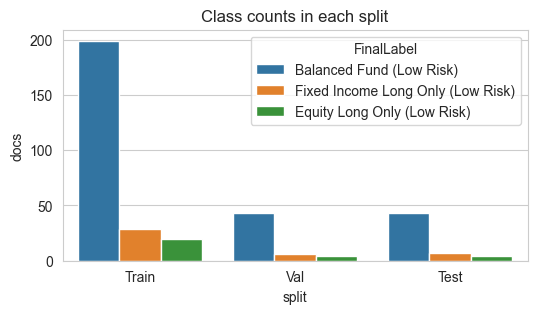

In [51]:
# ─────────────────────── 2. Train/Val/Test split ──────────────────────────
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df["FinalLabel"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["FinalLabel"], random_state=42
)
print(f"Train {len(train_df)} | Val {len(val_df)} | Test {len(test_df)}")

# ----- Visual 1: class balance ------------------------------------------------
fig, ax = plt.subplots(figsize=(6,3))
sns.countplot(data=pd.concat([
        train_df.assign(split="Train"),
        val_df.assign(split="Val"),
        test_df.assign(split="Test")]),
    x="split", hue="FinalLabel", ax=ax)
ax.set_title("Class counts in each split"); ax.set_ylabel("docs")
plt.show()

In [32]:
# ─────────────────────── 3. Clean text ────────────────────────────────────
clean = lambda t: re.sub(r"\s+", " ", t.replace("\n", " ")).strip()
for d in (train_df, val_df, test_df):
    d["clean_text"] = d["text"].apply(clean)

In [33]:
# ─────────────────────── 4. Skip‑gram Word2Vec ────────────────────────────
tokens = [simple_preprocess(t) for t in train_df["clean_text"]]
w2v = gensim.models.Word2Vec(tokens, vector_size=100, window=5,
                             min_count=2, workers=4, sg=1, epochs=5)

def doc_vec(txt:str)->np.ndarray:
    toks = [w for w in simple_preprocess(txt) if w in w2v.wv]
    return np.mean([w2v.wv[w] for w in toks], axis=0) if toks else np.zeros(100)

In [35]:
# ─────────────────────── 5. Centroids & similarities ──────────────────────
centroids = {}
for cls in train_df["FinalLabel"].unique():
    arr = np.vstack(train_df[train_df["FinalLabel"]==cls]["clean_text"].apply(doc_vec))
    c = arr.mean(axis=0); centroids[cls] = c/np.linalg.norm(c)

def sims(v):
    v = v/np.linalg.norm(v) if np.linalg.norm(v)!=0 else v
    return [np.dot(v,centroids["Balanced Fund (Low Risk)"]),
            np.dot(v,centroids["Equity Long Only (Low Risk)"]),
            np.dot(v,centroids["Fixed Income Long Only (Low Risk)"])]

for d in (train_df, val_df, test_df):
    d[["sim_bal","sim_eq","sim_fix"]] = d["clean_text"].apply(lambda t: pd.Series(sims(doc_vec(t))))

X_tr, X_val, X_te = (train_df[["sim_bal","sim_eq","sim_fix"]].values,
                     val_df[["sim_bal","sim_eq","sim_fix"]].values,
                     test_df[["sim_bal","sim_eq","sim_fix"]].values)

le = LabelEncoder()
y_tr, y_val, y_te = (le.fit_transform(train_df["FinalLabel"]),
                     le.transform(val_df["FinalLabel"]),
                     le.transform(test_df["FinalLabel"]))

centroids

{'Balanced Fund (Low Risk)': array([-0.0140291 ,  0.14505278,  0.11707637,  0.11471526,  0.09145321,
        -0.04229988,  0.19157892,  0.23807555, -0.07194067, -0.09091275,
         0.0905128 , -0.19324437,  0.01643742,  0.07520819, -0.013772  ,
        -0.11941465,  0.05710344, -0.03466075,  0.01022905, -0.17109436,
         0.17894009, -0.01351591,  0.00217701,  0.036274  ,  0.01073874,
         0.06128029, -0.04607755,  0.06461515, -0.14270619, -0.03331548,
         0.12499499, -0.04325036, -0.00354243, -0.21698222, -0.04215969,
         0.04909369,  0.09520369, -0.12402293,  0.02028086, -0.1566287 ,
         0.00939608, -0.11829667, -0.05928038,  0.00225787,  0.03768345,
         0.03372357, -0.07003631, -0.01388979,  0.10374242,  0.01367977,
         0.09901332, -0.11041587, -0.0081744 , -0.10078567, -0.06124082,
         0.04602372, -0.02232245, -0.03555465, -0.11945722, -0.0204027 ,
        -0.0548646 ,  0.02286238,  0.08621215, -0.06450976, -0.09636745,
         0.184065  , -0

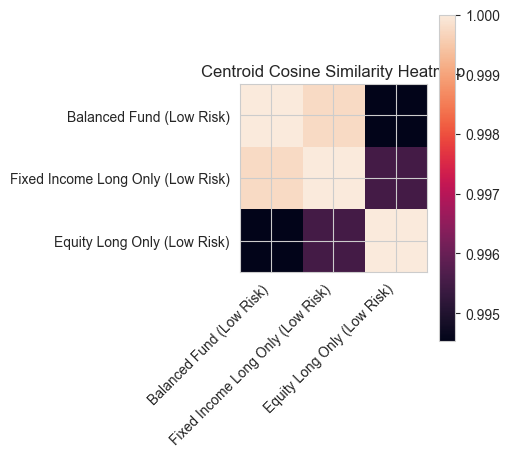

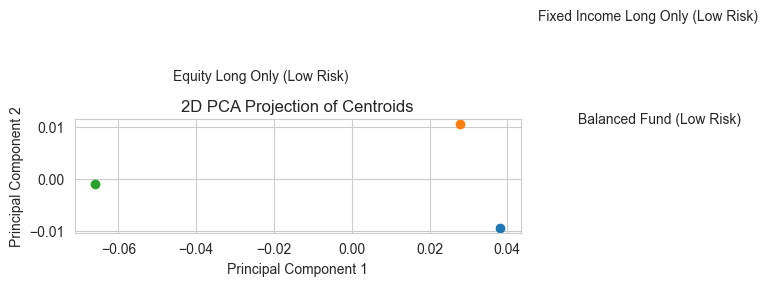

In [77]:
labels = list(centroids.keys())
vecs = np.vstack([centroids[label] for label in labels])

# 1) Cosine Similarity Heatmap
# Compute cosine similarity matrix
norms = np.linalg.norm(vecs, axis=1, keepdims=True)
cos_sim = (vecs @ vecs.T) / (norms * norms.T)

plt.figure(figsize=(5,5))
plt.imshow(cos_sim, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.yticks(range(len(labels)), labels)
plt.title('Centroid Cosine Similarity Heatmap')
plt.tight_layout()
plt.show()

# 2) PCA Projection of Centroids
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(vecs)

plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    x, y = proj[i]
    plt.scatter(x, y)
    plt.text(x + 0.02, y + 0.02, label)
plt.title('2D PCA Projection of Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

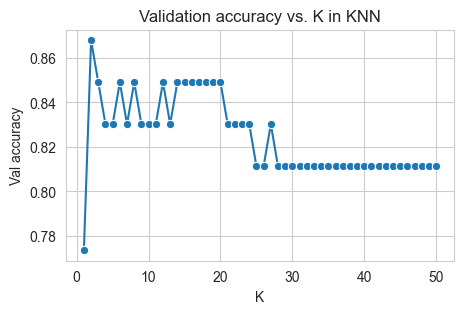


Chosen K = 2 (val acc=0.868)
Test accuracy  KNN      : 0.870
Test accuracy  Logistic : 0.796


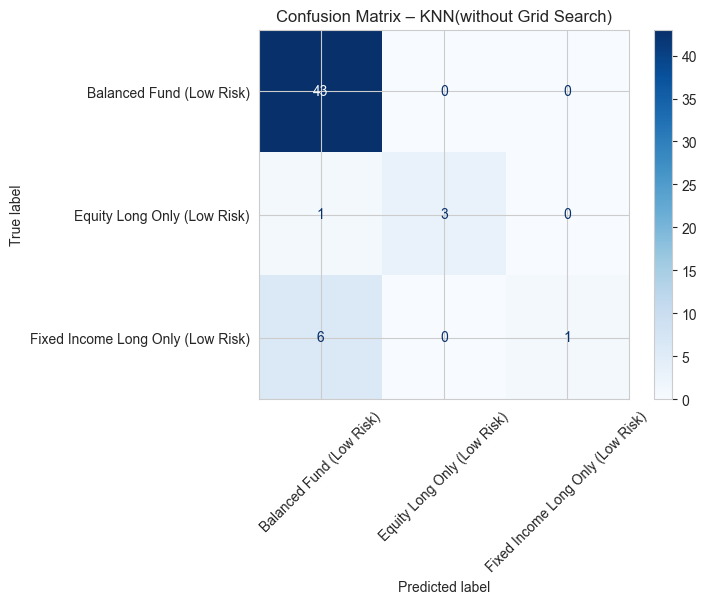


Detailed metrics:
                                    precision    recall  f1-score   support

         Balanced Fund (Low Risk)      0.860     1.000     0.925        43
      Equity Long Only (Low Risk)      1.000     0.750     0.857         4
Fixed Income Long Only (Low Risk)      1.000     0.143     0.250         7

                         accuracy                          0.870        54
                        macro avg      0.953     0.631     0.677        54
                     weighted avg      0.889     0.870     0.832        54



In [72]:
# ─────────────────────── 6. Model tuning ──────────────────────────────────
k_vals, val_scores = [], []
best_k, best_acc = 1, 0
for k in range(1,51):
    acc = KNeighborsClassifier(k).fit(X_tr,y_tr).score(X_val,y_val)
    k_vals.append(k); val_scores.append(acc)
    if acc>best_acc: best_k,best_acc=k,acc

# Visual 2: KNN validation curve
plt.figure(figsize=(5,3))
sns.lineplot(x=k_vals, y=val_scores, marker="o")
plt.title("Validation accuracy vs. K in KNN"); plt.xlabel("K"); plt.ylabel("Val accuracy")
plt.show()

knn  = KNeighborsClassifier(best_k).fit(X_tr,y_tr)
logr = LogisticRegression(max_iter=1000).fit(X_tr,y_tr)

print(f"\nChosen K = {best_k} (val acc={best_acc:.3f})")

# ─────────────────────── 7. Test evaluation ───────────────────────────────
acc_knn, acc_lr = knn.score(X_te,y_te), logr.score(X_te,y_te)
print(f"Test accuracy  KNN      : {acc_knn:.3f}")
print(f"Test accuracy  Logistic : {acc_lr:.3f}")

model = logr if acc_lr>=acc_knn else knn
y_pred = model.predict(X_te)

# Confusion matrix
cm = confusion_matrix(y_te,y_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix – KNN(without Grid Search)"); plt.xticks(rotation=45); plt.show()

# Classification report
print("\nDetailed metrics:\n",
      classification_report(y_te, y_pred, target_names=le.classes_, digits=3))


KNN  best params : {'n_neighbors': 30, 'weights': 'distance'}
KNN  CV accuracy : 0.844
LogReg best params: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
LogReg CV accuracy : 0.804

Selected model  : KNN

Test accuracy (KNN) : 0.833


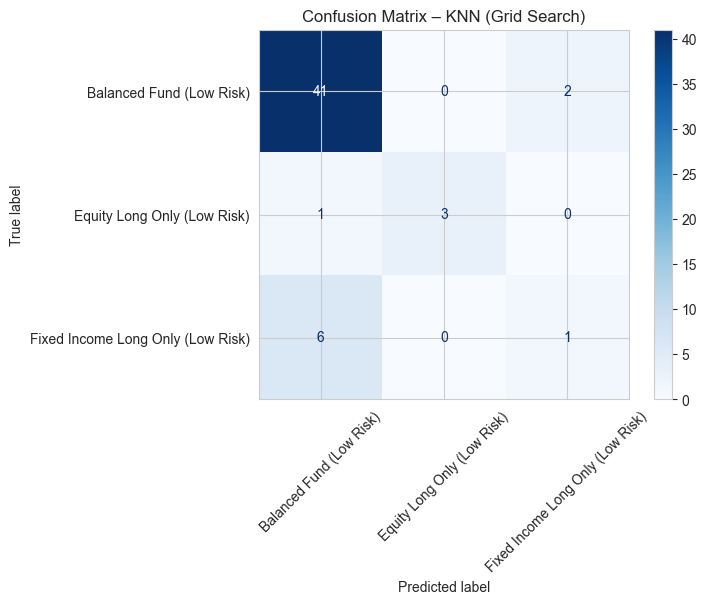


Classification report:
                                    precision    recall  f1-score   support

         Balanced Fund (Low Risk)      0.854     0.953     0.901        43
      Equity Long Only (Low Risk)      1.000     0.750     0.857         4
Fixed Income Long Only (Low Risk)      0.333     0.143     0.200         7

                         accuracy                          0.833        54
                        macro avg      0.729     0.615     0.653        54
                     weighted avg      0.797     0.833     0.807        54



In [ ]:
# ─────────────────────── 6. Model tuning ──────────────────────────────────
# -- merge train and val splits for cross‑validated search
X_cv = np.vstack([X_tr, X_val])
y_cv = np.concatenate([y_tr, y_val])

# ── 6‑A  KNN grid  (k = 1‒50, two weighting schemes) ----------------------
knn_param_grid = {
    "n_neighbors": list(range(1, 51)),          # 1 … 30
    "weights":     ["uniform", "distance"],     # two options
}

knn_gs = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0,
).fit(X_cv, y_cv)

print("KNN  best params :", knn_gs.best_params_)
print(f"KNN  CV accuracy : {knn_gs.best_score_:.3f}")

# ── 6‑B  Logistic‑Regression grid  (C across 5 decades) -------------------
log_param_grid = {
    "C":         [0.01, 0.1, 1, 10, 100],
    "penalty":   ["l2"],
    "solver":    ["lbfgs"],
    "max_iter":  [1000],
}

log_gs = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=log_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0,
).fit(X_cv, y_cv)

print("LogReg best params:", log_gs.best_params_)
print(f"LogReg CV accuracy : {log_gs.best_score_:.3f}")

# ── 6‑C Choose the higher CV‑score model -----------------------------------
best_model = log_gs if log_gs.best_score_ >= knn_gs.best_score_ else knn_gs
best_name  = "Logistic" if best_model is log_gs else "KNN"
print(f"\nSelected model  : {best_name}")

# ── 7  Evaluate on the held‑out test set ----------------------------------
y_pred = best_model.predict(X_te)
test_acc = (y_pred == y_te).mean()
print(f"\nTest accuracy ({best_name}) : {test_acc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_te, y_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap="Blues")
plt.title(f"Confusion Matrix – {best_name} (Grid Search)"); plt.xticks(rotation=45)
plt.show()

# Detailed metrics
from sklearn.metrics import classification_report
print("\nClassification report:\n",
      classification_report(y_te, y_pred, target_names=le.classes_, digits=3))

